# Setup

Import the libraries and methods required for the project.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    Embedding,
    Bidirectional,
    LSTM,
    Dense,
    Dropout
)
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

# Helper function

Create a helper function to make metric plots.

In [2]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_" + metric], "")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, "val_" + metric])

# Set up the input pipeline

Download the dataset.

In [3]:
dataset, info = tfds.load(name = "imdb_reviews",
                          as_supervised = True,
                          with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete3SQTLL/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete3SQTLL/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete3SQTLL/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [4]:
train = dataset["train"]
test = dataset["test"]

In [5]:
train.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Inspect the (text, label) pairs obtained.

In [6]:
for example, label in train.take(1):
    print("Text:", example.numpy())
    print("Label:", label.numpy())

Text: b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
Label: 0


Shuffle the data for training and create batches of these (text, label) pairs.

In [7]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [8]:
train = train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test = test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [9]:
for example, label in train.take(1):
    print("Texts:", example.numpy()[:3])
    print()
    print("Labels:", label.numpy()[:3])

Texts: [b"I personally watched this to see the footage of the 60's and 70's. It was fascinating to learn how the drug movement essentially started and became pop culture and an eventual uncompromising force in life. The interviews of the classic rock stars are titillating and humorous. You feel like you're in on a secret and nodding your head at the same time...because it feels so good and familiar. I loved it, all segments from 60's-present day. I highly recommend this for all aspects, including rock music, the hipper movement, politics and good 'ol history. I check marked the box saying this contains a spoiler, only because I have no idea what some might consider a spoiler or not in this regards, since I discussed what's in all 4 segments, so just wanted to be safe."
 b"Extremely poor action film starring the ever wooden Dolph Lundgren and Brandon Lee trapped in a sidekick role that never seems to gel. The action is at best average, a bit of nudity chucked in and yes Tia Carrera does

# Create the text encoder

Use the TextVectorization layer to encode each word in the text to an index. Create the layer and pass the dataset's text to the layer's .adapt() method.

In [10]:
VOCAB_SIZE = 1000
encoder = TextVectorization(max_tokens = VOCAB_SIZE)
encoder.adapt(train.map(lambda text, label: text))

The vocabulary has been set. Print the first 20 tokens of the vocabulary. After the padding and the unknown tokens, the remaining tokens are in decreasing order of frequency.

In [11]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

The tensors of indices are zero-padded to the longest sequence in the batch.

In [12]:
encoded_example = encoder(example)[:3].numpy()

encoded_example

array([[ 10,   1, 284, ...,   0,   0,   0],
       [554, 330, 216, ...,   0,   0,   0],
       [ 11,  18,   7, ...,   0,   0,   0]])

With the default settings, this encoding process is not completely reversible. This is because firstly, the limit on the vocab size leads to the presence of unknown tokens in the vocab which can't be retraced back to their original words. Secondly, text is converted to lower case and stripped of punctuation during tokenization. Hence, upper case characters and punctuation marks cannot be regained.

In [13]:
for n in range(3):
    print("Original:", example[n].numpy())
    print("Round-trip:", " ".join(vocab[encoded_example[n]]))
    print()

Original: b"I personally watched this to see the footage of the 60's and 70's. It was fascinating to learn how the drug movement essentially started and became pop culture and an eventual uncompromising force in life. The interviews of the classic rock stars are titillating and humorous. You feel like you're in on a secret and nodding your head at the same time...because it feels so good and familiar. I loved it, all segments from 60's-present day. I highly recommend this for all aspects, including rock music, the hipper movement, politics and good 'ol history. I check marked the box saying this contains a spoiler, only because I have no idea what some might consider a spoiler or not in this regards, since I discussed what's in all 4 segments, so just wanted to be safe."
Round-trip: i [UNK] watched this to see the footage of the [UNK] and 70s it was [UNK] to learn how the [UNK] [UNK] [UNK] started and became [UNK] [UNK] and an [UNK] [UNK] [UNK] in life the [UNK] of the classic rock sta

# Create the model

Define the model's architecture.

In [14]:
model = Sequential([
    encoder,
    Embedding(input_dim = len(encoder.get_vocabulary()),
              output_dim = 64,
              # use masking to handle the variable sequence lengths
              mask_zero = True),
    Bidirectional(layer = LSTM(units = 64,
                               return_sequences = True)),
    Bidirectional(layer = LSTM(units = 32)),
    Dense(units = 64, activation = "relu"),
    Dropout(rate = 0.5),
    Dense(units = 1)
])

Each layer after the Embedding layer supports masking.

In [15]:
[layer.supports_masking for layer in model.layers]

[False, True, True, True, True, True, True]

To confirm the above, evaluate the same sentence twice. First, evaluate it without any padding.

In [16]:
# Predict on a sample text without padding

sample_text = "The movie was cool. The animation and the graphics were out of this world. I would recommend this movie."
predictions = model.predict(np.array([sample_text]))

predictions[0]

array([-0.00047284], dtype=float32)

Then, evaluate it in a batch with a longer sentence.

In [17]:
# Predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))

predictions[0]

array([-0.00047284], dtype=float32)

Observe that the results with and without padding are identical.

Compile the model with a loss function, an optimizer and a metric.

In [18]:
model.compile(loss = BinaryCrossentropy(from_logits = True),
              optimizer = Adam(learning_rate = 1e-4),
              metrics = ["accuracy"])

# Train the model

Train the model for the desired number of epochs.

In [19]:
history = model.fit(train,
                    epochs = 30,
                    validation_data = test)

Epoch 1/30
391/391 [==============================] - 99s 218ms/step - loss: 0.6825 - accuracy: 0.5184 - val_loss: 0.4255 - val_accuracy: 0.8094
Epoch 2/30
391/391 [==============================] - 81s 207ms/step - loss: 0.4151 - accuracy: 0.8090 - val_loss: 0.3441 - val_accuracy: 0.8494
Epoch 3/30
391/391 [==============================] - 82s 208ms/step - loss: 0.3476 - accuracy: 0.8497 - val_loss: 0.3221 - val_accuracy: 0.8535
Epoch 4/30
391/391 [==============================] - 82s 208ms/step - loss: 0.3204 - accuracy: 0.8639 - val_loss: 0.3176 - val_accuracy: 0.8602
Epoch 5/30
391/391 [==============================] - 81s 206ms/step - loss: 0.3202 - accuracy: 0.8628 - val_loss: 0.3123 - val_accuracy: 0.8637
Epoch 6/30
391/391 [==============================] - 82s 208ms/step - loss: 0.3066 - accuracy: 0.8679 - val_loss: 0.3149 - val_accuracy: 0.8558
Epoch 7/30
391/391 [==============================] - 82s 208ms/step - loss: 0.3014 - accuracy: 0.8706 - val_loss: 0.3336 - val_ac

Evaluate the model on the test set.

In [20]:
test_loss, test_accuracy = model.evaluate(test)

print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

391/391 [==============================] - 26s 66ms/step - loss: 0.3540 - accuracy: 0.8516
Test loss: 0.3539840579032898
Test accuracy: 0.8515999913215637


Plot the metrics for the training process.

(0.0, 0.6509137965738774)

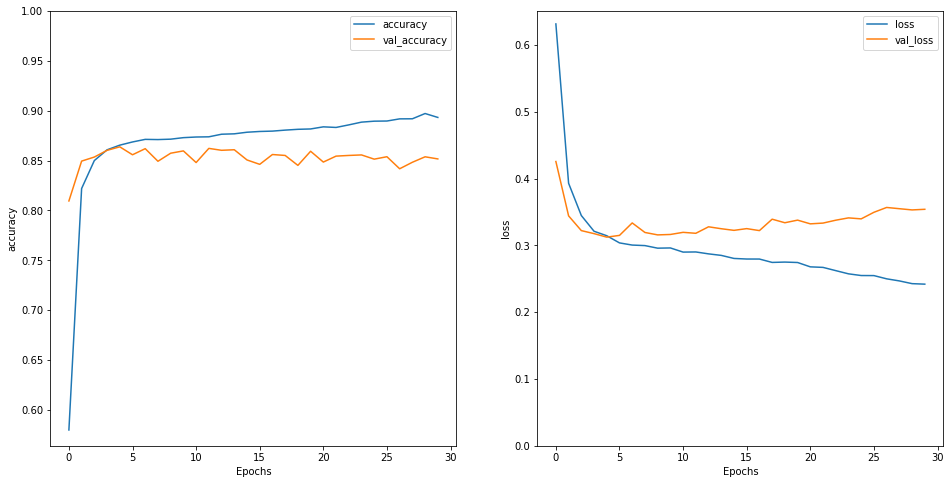

In [21]:
plt.figure(figsize = (16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, "loss")
plt.ylim(0, None)

# Make predictions on new data

Come up with a new review of your own and let the model figure out whether it's positive or negative.

In [22]:
sample_text = "The movie was cool. The animation and the graphics were out of this world. I would recommend this movie."
predictions = model.predict(np.array([sample_text]))

predictions[0]

array([-0.27691582], dtype=float32)

Save the model to disk.

In [23]:
model.save("tensorflow-model")